In [2]:
import pandas as pd
import numpy as np
import nltk
import pickle
from contextlib import contextmanager
import copy
import os
import re
import string
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [4]:
# with timer('load pickle'):
#     with open('preprocessed_data', mode='rb') as f:
#         data = pickle.load(f)

In [5]:
data = pd.read_csv('cleaned_short.csv')

In [7]:
data.comment_text

0         this is a great story      man      i wonder i...
1         yet call out all muslims for the acts of a few...
2         because the people who drive cars more are the...
3         mormons have had a complicated relationship wi...
4                   i am doing the same thing              
                                ...                        
235082    xi and his comrades must be smirking over trum...
235083    my thought exactly       the only people he ha...
235084    i agree      bill g\nthe vote     buying has b...
235085    no      the probability of dying may be very  ...
235086    nah      i am too boring to parody       this ...
Name: comment_text, Length: 235087, dtype: object

In [5]:
with timer('TFIDF'):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
    tfidf_doc = tfidf.fit_transform(data.comment_text)

[TFIDF] start.
[TFIDF] done in 1.34 min.


In [6]:
# with open('tfidf_bigram', mode='wb') as f:
#     pickle.dump(tfidf_doc, f)

In [7]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
with timer('SVD'):
    lsa = TruncatedSVD(30)
    doc_topic = lsa.fit_transform(tfidf_doc)

[SVD] start.
[SVD] done in 2.47 min.


In [8]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
display_topics(lsa, tfidf.get_feature_names(), 10)


Topic  0
people, like, just, trump, did, women, white, does, think, know

Topic  1
trump, white, black, president, obama, racist, people, white people, supremacists, clinton

Topic  2
trump, did, said, president, clinton, women, hillary, donald, obama, donald trump

Topic  3
white, church, trump, god, catholic, jesus, said, catholic church, black, christ

Topic  4
women, men, white, trump, men women, church, man, male, woman, sexual

Topic  5
said, did, jesus, know, man, god, white, men, say, women

Topic  6
yes, white, right, yes yes, yes know, yes did, catholic, agree, ah yes, yes does

Topic  7
right, said, wing, did, right wing, left, alt, wrong, alt right, woman

Topic  8
said, people, like, yes, tax, agree, pay, jesus said, does, government

Topic  9
god, know, man, like, jesus, love, trump, does, right, good

Topic  10
like, just, church, catholic, just like, sounds, know, sounds like, catholic church, said

Topic  11
know, said, catholic, church, catholic church, really, think

In [10]:
def components(n):
    return ['component_{0}'.format(s) for s in range(1, n+1)]

In [11]:
doc_topic = pd.DataFrame(doc_topic.round(5), index=data.comment_text, columns=components(30))

In [12]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [13]:
y = np.where(data['target'] >= 0.5, 1, 0)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(doc_topic, y, test_size=0.3, random_state=42, stratify=y)
x_balance, y_balance = RandomOverSampler().fit_sample(x_train, y_train)
x_balance = pd.DataFrame(x_balance, columns=x_train.columns)

In [15]:
lr.fit(x_balance, y_balance)
y_pred = lr.predict(x_test)

/Users/kelvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

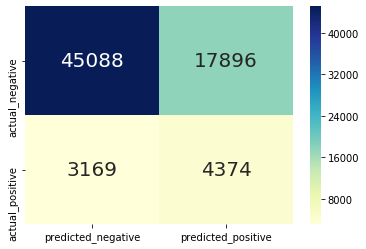

In [17]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred)

In [18]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_TFIDF']
results

,LogReg_TFIDF
Accuracy,0.701
Precision,0.196
Recall,0.580
F1 Score,0.293


In [19]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_balance, y_balance)
y_pred_nb = bnb.predict(x_test)

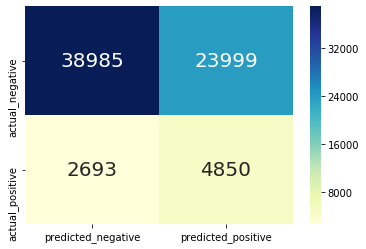

In [20]:
# Here's the heat map for the first Naive Bayes model
cm2 = conf_matrix(y_test, y_pred_nb)

In [21]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_TFIDF', 'NB_TFIDF']
results

,LogReg_TFIDF,NB_TFIDF
Accuracy,0.701,0.622
Precision,0.196,0.168
Recall,0.580,0.643
F1 Score,0.293,0.266


[timer] start.


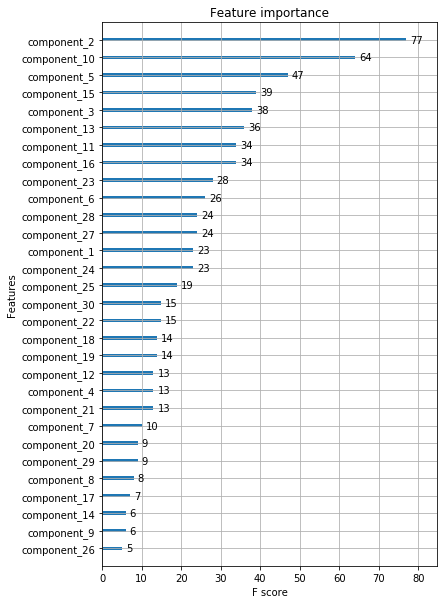

ROC_AUC:  0.6636246336449548
[[43098 19886]
 [ 2693  4850]]
[timer] done in 1.44 min.


In [22]:
with timer('timer'):
    model = XGBClassifier()
    model.fit(x_balance, y_balance)
    # plot feature importance
    ax = plot_importance(model)
    fig = ax.figure
    fig.set_size_inches(6, 10)
    pyplot.show()
    predict = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("ROC_AUC: ", roc_auc)
    print(confusion_matrix(y_test, predict))

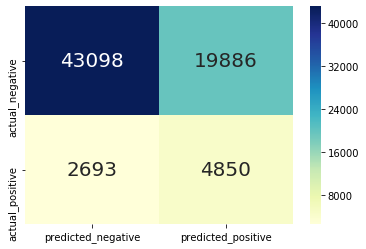

In [23]:
cm3 = conf_matrix(y_test, predict)

In [25]:
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_TFIDF', 'NB_TFIDF', 'XBG_TFIDF']
results

,LogReg_TFIDF,NB_TFIDF,XBG_TFIDF
Accuracy,0.701,0.622,0.680
Precision,0.196,0.168,0.196
Recall,0.580,0.643,0.643
F1 Score,0.293,0.266,0.300


## Feature COEFS LOGREG

In [26]:
coefficients = pd.concat(
    [pd.DataFrame(components(30), columns=["feature"]), pd.DataFrame(np.transpose(lr.coef_), columns=["coef"])],
    axis=1)
coefficients = coefficients.sort_values(by="coef", ascending=False)

In [27]:
coefficients

,feature,coef
1,component_2,16.259251
15,component_16,11.524851
4,component_5,8.802463
10,component_11,7.416151
27,component_28,7.170793
9,component_10,6.961034
12,component_13,6.522718
14,component_15,6.387716
23,component_24,5.365518
3,component_4,5.156098


In [8]:
import pandas as pd
import numpy as np
import nltk
import pickle
from contextlib import contextmanager
import copy
import os
import re
import string
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [10]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [11]:
data = pd.read_csv('cleaned_short_simple.csv')

In [12]:
any(data.comment_text.isnull())

True

In [13]:
data.comment_text = data.comment_text.replace(np.nan, '')

In [15]:
with timer('TFIDF'):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
    tfidf_doc = tfidf.fit_transform(data.comment_text)

[TFIDF] start.
[TFIDF] done in 0.74 min.


In [53]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
with timer('SVD'):
    lsa = TruncatedSVD(50)
    doc_topic = lsa.fit_transform(tfidf_doc)

[SVD] start.
[SVD] done in 2.69 min.


In [54]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [55]:
#display_topics(lsa, tfidf.get_feature_names(), 10)

In [56]:
def components(n):
    return ['component_{0}'.format(s) for s in range(1, n+1)]

In [57]:
doc_topic = pd.DataFrame(doc_topic, index=data.comment_text, columns=components(50))

## Modeling

In [58]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [59]:
y = data.y

In [60]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(doc_topic, y, test_size=0.25, random_state=42, stratify=y)
x_balance, y_balance = RandomOverSampler().fit_sample(x_train, y_train)
x_balance = pd.DataFrame(x_balance, columns=x_train.columns)

In [61]:
lr.fit(x_balance, y_balance)
y_pred = lr.predict(x_test)

/Users/kelvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


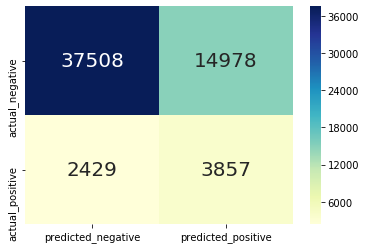

In [62]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred)

In [63]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_balance, y_balance)
y_pred_nb = bnb.predict(x_test)

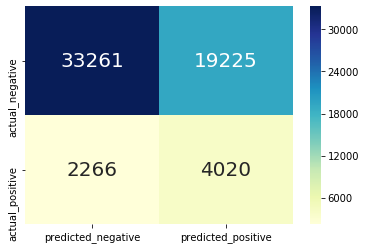

In [64]:
# Here's the heat map for the first Naive Bayes model
cm2 = conf_matrix(y_test, y_pred_nb)

[timer] start.


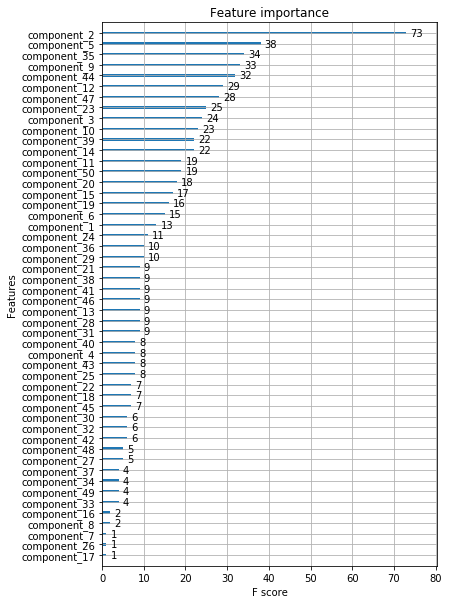

[timer] done in 3.87 min.


In [65]:
with timer('timer'):
    model = XGBClassifier()
    model.fit(x_balance, y_balance)
    # plot feature importance
    ax = plot_importance(model)
    fig = ax.figure
    fig.set_size_inches(6, 10)
    pyplot.show()
    predict = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)

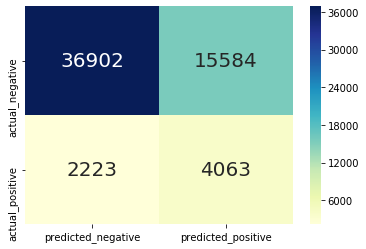

In [66]:
cm3 = conf_matrix(y_test, predict)

In [67]:
# 50 topic Oversample
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.704,0.634,0.697
Precision,0.205,0.173,0.207
Recall,0.614,0.640,0.646
F1 Score,0.307,0.272,0.314


In [52]:
# 40 topic Oversample
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.693,0.632,0.690
Precision,0.195,0.169,0.202
Recall,0.599,0.621,0.641
F1 Score,0.294,0.266,0.307


In [37]:
# 30 topic Oversample
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.712,0.627,0.690
Precision,0.198,0.164,0.198
Recall,0.555,0.608,0.623
F1 Score,0.292,0.258,0.300
